In [66]:
import pandas as pd
cars_df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [67]:
features = ['engine_displacement',
            'horsepower',
            'vehicle_weight',
            'model_year']
df = cars_df[features].copy()

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

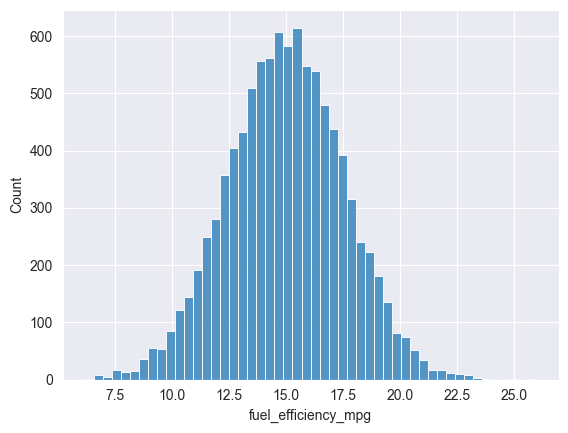

In [68]:
import seaborn as sns

sns.histplot(cars_df.fuel_efficiency_mpg, bins=50)

#### Q1

In [69]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
dtype: int64

#### Q2

In [70]:
cars_df['horsepower'].median()

np.float64(149.0)

#### Prepare and split the dataset

In [71]:
import numpy as np


class ModelData:
    def __init__(self, df: pd.DataFrame, random_seed: int, target_var: str, *features: str):
        self._df = df.copy()
        self._target_var = target_var
        self._features = list(features)

        self._n = len(df)
        self._n_val = int(self._n * 0.2)
        self._n_test = int(self._n * 0.2)
        self._n_train = self._n - self._n_val - self._n_test

        self._random_seed = random_seed
        np.random.seed(self._random_seed)
        idx = np.arange(self._n)
        np.random.shuffle(idx)

        self._df_train = self._df[self._features].iloc[idx[:self._n_train]]
        self._df_val = self._df[self._features].iloc[idx[self._n_train:self._n_train + self._n_val]]
        self._df_test = self._df[self._features].iloc[idx[self._n_train + self._n_val:]]

        self._y_train = self._df[self._target_var].iloc[idx[:self._n_train]].values
        self._y_val = self._df[self._target_var].iloc[idx[self._n_train:self._n_train + self._n_val]].values
        self._y_test = self._df[self._target_var].iloc[idx[self._n_train + self._n_val:]].values

    def reinit(self, new_seed: int) -> 'ModelData':
        return ModelData(self._df, new_seed, self._target_var, *self._features)

In [72]:
model_data = ModelData(cars_df, 42, 'fuel_efficiency_mpg', *features)

#### Q3

In [73]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [74]:
def rsme(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [75]:
fill_values = [0, model_data._df_train['horsepower'].mean()]
def prepare_X(df_x, fill_value):
    df_x = df_x.copy()
    df_x['horsepower'] = df_x['horsepower'].fillna(fill_value)
    return df_x.values

for f_val in fill_values:
    X_train = prepare_X(model_data._df_train, f_val)
    w0, w = train_linear_regression(X_train, model_data._y_train)
    
    X_val = prepare_X(model_data._df_val, f_val)
    y_pred = w0 + X_val.dot(w)
    score = rsme(model_data._y_val, y_pred)
    print(f'Fill value: {f_val}, RSME: {score:.2f}')

Fill value: 0, RSME: 0.52
Fill value: 149.54476367006487, RSME: 0.46


#### Q4

In [76]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
def prepare_X(df_x):
    df_x = df_x.copy()
    df_x['horsepower'] = df_x['horsepower'].fillna(0)
    return df_x.values

def train_linear_regression_with_regularization(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]
    
X_train = prepare_X(model_data._df_train)
X_val = prepare_X(model_data._df_val)
for r in r_values:
    w0, w = train_linear_regression_with_regularization(X_train, model_data._y_train, r)
    
    y_pred = w0 + X_val.dot(w)
    score = rsme(model_data._y_val, y_pred)
    print(f'R: {r}, RSME: {score:.2f}')

R: 0, RSME: 0.52
R: 0.01, RSME: 0.52
R: 0.1, RSME: 0.52
R: 1, RSME: 0.52
R: 5, RSME: 0.52
R: 10, RSME: 0.52
R: 100, RSME: 0.52


#### Q5

In [77]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def model_score(model_data):
    X_train = prepare_X(model_data._df_train)
    X_val = prepare_X(model_data._df_val)
    
    w0, w = train_linear_regression(X_train, model_data._y_train)
    y_pred = w0 + X_val.dot(w)
    score = rsme(model_data._y_val, y_pred)
    return score

scores = [model_score(model_data.reinit(x)) for x in seeds]
print(f'Std of scores: {np.std(scores):.3f}')

Std of scores: 0.007


#### Q6

In [78]:
model_data = model_data.reinit(9)
X_train = prepare_X(pd.concat([model_data._df_train, model_data._df_val]))
y_train = np.concatenate([model_data._y_train, model_data._y_val])
w0, w = train_linear_regression_with_regularization(X_train, y_train, 0.001)

X_test = prepare_X(model_data._df_test)
y_pred = w0 + X_test.dot(w)
score = rsme(model_data._y_test, y_pred)
print(f'Test RSME: {score:.3f}')

Test RSME: 0.516
